# Autonomous robot navigating a smart farm
•	🛠 Dynamic environment (battery drain, growing weeds). \
•	⚡ Charging management (robot must collect batteries). \
•	📈 visualization results (graph learning progress).

1. Importing required libraries

In [3]:
import numpy as np
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

### 2. Defining RL environment
##### 🏡 Smart Farm Reinforcement Learning Environment

In this section, I define a **custom RL environment** for an **autonomous farm robot** using OpenAI's `gym` framework.  
The goal of this agent is to **navigate a 5x5 farm**, avoid **rocks (🪨)**, collect **batteries (🔋)**, and clear **weeds (🌿)** while managing its energy.

### **The agent is trained according to the following rules:**
✅ **Obstacles:** Rocks `🪨`.  
✅ **Rewards:** The agent earns rewards by clearing weeds `🌿` and reaching the goal `🏁`.  
✅ **Battery Management:** The agent loses energy with every move but can recharge by collecting batteries `🔋`.  
✅ **Goal:** The mission is complete when the agent reaches the goal `🏁` at `(4,4)`.

In [ ]:
class SmartFarmEnv(gym.Env):
    """
    Custom RL Environment: An autonomous farm robot must clear weeds, avoid rocks, 
    and manage battery power while navigating a 5x5 smart farm grid.
    """
    
    def __init__(self):
        super(SmartFarmEnv, self).__init__()
        self.grid_size = (5, 5)
        self.num_states = self.grid_size[0] * self.grid_size[1]
        self.action_space = spaces.Discrete(4)  # actions: 0=Up, 1=Down, 2=Left, 3=Right
        self.observation_space = spaces.Discrete(self.num_states)

        self.rewards = np.zeros(self.grid_size)
        self.static_objects = {}  # Store objects separately to keep them visible
        # initialising reqwards and Obstacles  
        # rocks (obstacles)
        self.static_objects[(1, 2)] = "🪨"
        self.static_objects[(3, 1)] = "🪨"
        self.static_objects[(3, 4)] = "🪨"

        # weeds (the robot earns reward if it clears weeds)
        self.static_objects[(2, 3)] = "🌿"
        self.static_objects[(1, 4)] = "🌿"
        self.static_objects[(3, 2)] = "🌿"

        # btteries (energy refills)
        self.static_objects[(0, 3)] = "🔋"

        # goal
        self.static_objects[(4, 4)] = "🏁"

        # adding emojis to enable easier interpretability 
        for (i, j), obj in self.static_objects.items():
            if obj == "🪨":  # rocks - negative
                self.rewards[i, j] = -5
            elif obj == "🌿":  # weeds - clearing it gives small psotive reward
                self.rewards[i, j] = 3
            elif obj == "🔋":  # batteries resores energy
                self.rewards[i, j] = 5
            elif obj == "🏁":  # Goal - biggest reward
                self.rewards[i, j] = 10

        self.start_pos = (0, 0)  
        self.state = self.start_pos
        self.energy = 10  # Robot starts with 10 energy points

    def step(self, action):
        """
        Moves the agent and applies environment effects.
        """
        moves = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        new_state = (self.state[0] + moves[action][0], self.state[1] + moves[action][1])

        # Check boundary conditions to ensure the robot doesnt exit the gid
        if 0 <= new_state[0] < self.grid_size[0] and 0 <= new_state[1] < self.grid_size[1]:
            self.state = new_state
        else:
            new_state = self.state  # be in place if hitting a boundary

        reward = self.rewards[self.state]

        # ensure same rweard isnt collected multiple times
        if self.state != (4, 4):  
            self.rewards[self.state] = 0

        self.energy -= 1  # Moving consumes energy

        # Game Over conditions
        done = self.state == (4, 4) or self.energy <= 0
        return self.state, reward, done, {"Energy": self.energy}

    def reset(self):
        """
        Resets environment to initial state.
        """
        self.state = self.start_pos
        self.energy = 10  
        return self.state

    def render(self):
        """
        Displays the grid environment.
        """
        grid = np.full(self.grid_size, "⬜", dtype=str)  # empty grid

        # keep static objects visible whilst navigating
        for (i, j), obj in self.static_objects.items():
            grid[i, j] = obj
 
        grid[self.state] = "🤖"

        # Print grid
        print("\n".join([" ".join(row) for row in grid]))
        print(f"🔋 Energy: {self.energy}\n")

# 🧠 SARSA Learning Algorithm for Training

Now that the environment is ready, I implement **SARSA (State-Action-Reward-State-Action)** to train the agent.

### **How SARSA Works**
1️⃣ The agent selects an action using the **epsilon-greedy policy**.  
2️⃣ It takes a step in the environment and receives a **reward**.  
3️⃣ It selects the next action based on the new state.  
4️⃣ It updates the **Q-values** based on its experience.  
5️⃣ This process repeats until the agent either **reaches the goal** or **runs out of energy**.

### **Hyperparameters Used**
- **Learning Rate (`alpha=0.1`)** – Determines how much new experiences override old ones.
- **Discount Factor (`gamma=0.9`)** – Controls how much future rewards matter.
- **Exploration Rate (`epsilon=1.0 → 0.1`)** – Starts exploring randomly and gradually shifts to exploitation.

This will help the agent **learn an optimal policy** over multiple training episodes.

In [3]:
def epsilon_greedy(Q, state_idx, epsilon, n_actions):
    """
    Chooses an action using the epsilon-greedy policy.
    """
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(Q[state_idx])

def sarsa(env, episodes, alpha, gamma, epsilon, epsilon_decay, min_epsilon, max_steps):
    """
    SARSA Algorithm for reinforcement learning.
    """
    Q = np.zeros((env.num_states, env.action_space.n))
    rewards_per_episode = []

    for episode in range(episodes):
        state = env.reset()
        state_idx = state[0] * env.grid_size[1] + state[1]
        action = epsilon_greedy(Q, state_idx, epsilon, env.action_space.n)
        total_reward = 0
        done = False
        step_count = 0

        while not done and step_count < max_steps:
            next_state, reward, done, info = env.step(action)
            next_state_idx = next_state[0] * env.grid_size[1] + next_state[1]
            next_action = epsilon_greedy(Q, next_state_idx, epsilon, env.action_space.n)

            Q[state_idx, action] += alpha * (
                reward + gamma * Q[next_state_idx, next_action] - Q[state_idx, action])

            state_idx = next_state_idx
            action = next_action
            total_reward += reward
            step_count += 1

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

    return Q, rewards_per_episode

# 📊 Training the RL Agent

Now, I train the **SmartFarm RL agent** using the SARSA algorithm.  
This will allow the agent to **learn the best path** to reach the goal (`🏁`) while avoiding rocks (`🪨`), collecting batteries (`🔋`), and clearing weeds (`🌿`).

### **Training Progress Visualization**
- **X-axis:** Number of episodes (iterations of learning).
- **Y-axis:** Total rewards collected in each episode.

As training progresses, the agent should **collect more rewards** as it learns a **better strategy** for navigating the farm.

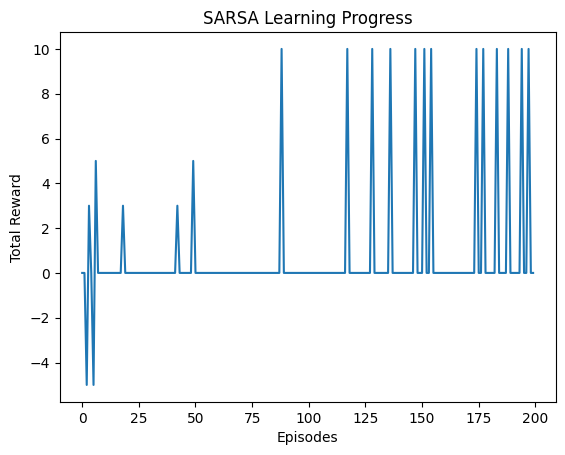

In [ ]:
env = SmartFarmEnv()
Q, rewards_per_episode = sarsa(env, episodes=200, alpha=0.1, gamma=0.9, 
                               epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1, max_steps=50)

# plotting rewards over episodes
plt.plot(rewards_per_episode)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA Learning Progress')
plt.show()

# 🎯 Greedy Policy Evaluation (Testing the Trained Agent)

Now that training is complete, it's time to **test** how well the agent performs.

### **How This Works**
✅ The agent **follows the best learned policy** (greedy strategy).  
✅ It starts at `(0,0)`, and moves based on the **highest Q-value** at each step.  
✅ The **environment is rendered dynamically**, showing:
   - The **robot (`🤖`) moving step-by-step**.
   - **Obstacles (`🪨`) and batteries (`🔋`) remaining in place**.
   - The **goal (`🏁`) staying visible**.

If the training was successful, the agent should **efficiently reach the goal** while optimizing for rewards and energy.

In [ ]:
def greedy_evaluation(env, Q, episodes=3, max_steps=50):
    """
    Evaluates the trained model using a greedy policy with improved visualization.
    """
    for episode in range(episodes):
        print(f"\n🟢 Greedy Evaluation - Episode {episode + 1}")
        state = env.reset()
        state_idx = state[0] * env.grid_size[1] + state[1]
        total_reward = 0
        done = False
        step_count = 0

        while not done and step_count < max_steps:
            env.render()  # display grid at each step with all the emojis!
            action = np.argmax(Q[state_idx])  #  best action taken based on learning
            next_state, reward, done, info = env.step(action) 
            next_state_idx = next_state[0] * env.grid_size[1] + next_state[1]
            total_reward += reward

            state_idx = next_state_idx
            step_count += 1

        if done:
            print("🏆 Goal reached!" if state == (4,4) else "❌ Battery depleted!")

# visualize movement and here we go!
greedy_evaluation(env, Q)


🟢 Greedy Evaluation - Episode 1
🤖 ⬜ ⬜ 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ ⬜ 🌿 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 10

⬜ 🤖 ⬜ 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ ⬜ 🌿 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 9

⬜ ⬜ 🤖 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ ⬜ 🌿 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 8

⬜ ⬜ ⬜ 🔋 ⬜
⬜ ⬜ 🤖 ⬜ 🌿
⬜ ⬜ ⬜ 🌿 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 7

⬜ ⬜ ⬜ 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ 🤖 🌿 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 6

⬜ ⬜ ⬜ 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ ⬜ 🤖 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 5

⬜ ⬜ ⬜ 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ ⬜ 🌿 🤖
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 4

⬜ ⬜ ⬜ 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ ⬜ 🌿 ⬜
⬜ 🪨 🌿 ⬜ 🤖
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 3

❌ Battery depleted!

🟢 Greedy Evaluation - Episode 2
🤖 ⬜ ⬜ 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ ⬜ 🌿 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 10

⬜ 🤖 ⬜ 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ ⬜ 🌿 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 9

⬜ ⬜ 🤖 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ ⬜ 🌿 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 8

⬜ ⬜ ⬜ 🔋 ⬜
⬜ ⬜ 🤖 ⬜ 🌿
⬜ ⬜ ⬜ 🌿 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 7

⬜ ⬜ ⬜ 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ 🤖 🌿 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 6

⬜ ⬜ ⬜ 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ ⬜ 🤖 ⬜
⬜ 🪨 🌿 ⬜ 🪨
⬜ ⬜ ⬜ ⬜ 🏁
🔋 Energy: 5

⬜ ⬜ ⬜ 🔋 ⬜
⬜ ⬜ 🪨 ⬜ 🌿
⬜ ⬜ ⬜ 🌿 🤖


### End